In [ ]:
! nvidia-smi

Fri Jan 29 15:39:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
 ! pip install -q kaggle
 from google.colab import files
 from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Get kaggle token and downaload dataset

In [ ]:
# ! mkdir ~/.kaggle
# ! cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# ! kaggle datasets download jerzydziewierz/bee-vs-wasp --unzip

In [ ]:
# ! cp -a  /content/kaggle_bee_vs_wasp /content/gdrive/MyDrive/

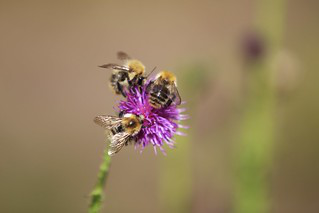

In [ ]:
import PIL
import PIL.Image
PIL.Image.open("/content/gdrive/MyDrive/kaggle_bee_vs_wasp/bee1/10166485783_9cd6706c72_n.jpg")

In [ ]:
pip install fastai --upgrade &> /dev/null # &> /dev/null - hides output

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision.all import *
from fastai.metrics import error_rate

# additional classic imports
from pathlib import Path
import pandas as pd
import numpy as np
import random

In [ ]:
bs = 32 # Batch size
resize_size = 224 # for training, resize all the images to a square of this size
training_subsample = 1 # for development, use a small fraction of the entire dataset

In [ ]:
bees_vs_wasps_dataset_path=Path('/content/gdrive/MyDrive/kaggle_bee_vs_wasp/') 
df_labels = pd.read_csv(bees_vs_wasps_dataset_path/'labels.csv')
df_labels=df_labels.set_index('id')

In [ ]:
df_labels = df_labels.sample(frac=training_subsample, axis=0)
df_labels.size

102789

In [ ]:
df_labels.shape

(11421, 9)

In [ ]:
df_labels[['path']] = df_labels[['path']].replace(to_replace= r'\\', value= r'/', regex=True)
df_labels.head(10)


,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
id,,,,,,,,,
6677,wasp2/H00330.jpg,0,1,0,0,0,0,0,wasp
10281,other_insect/7173371961_443538d4e9_w.jpg,0,0,1,0,1,0,0,insect
1486,bee1/4544074246_5380468d24_n.jpg,1,0,0,0,1,0,1,bee
11325,other_noinsect/572245.jpg,0,0,0,1,0,0,0,other
2401,bee1/9488053514_838fb41ec3_n.jpg,1,0,0,0,1,1,0,bee
4313,wasp1/3873037640_f2bbf8b55f_n.jpg,0,1,0,0,1,0,0,wasp
6226,wasp2/G00274.jpg,0,1,0,0,0,0,0,wasp
10096,other_insect/5655011279_d1d606c1c9_n.jpg,0,0,1,0,1,0,0,insect
6947,wasp2/I00206.jpg,0,1,0,0,0,0,0,wasp


In [ ]:
data = ImageDataLoaders.from_df(
    df = df_labels,
    path = Path(bees_vs_wasps_dataset_path),
    valid_pct=0.2,
    seed = 5,
    fn_col='path',
    folder=None,
    label_col='label',
    bs=bs,
    shuffle_train=True,
    batch_tfms=aug_transforms(),
    item_tfms=Resize(resize_size),
    device='cuda', 
    num_workers=0
)

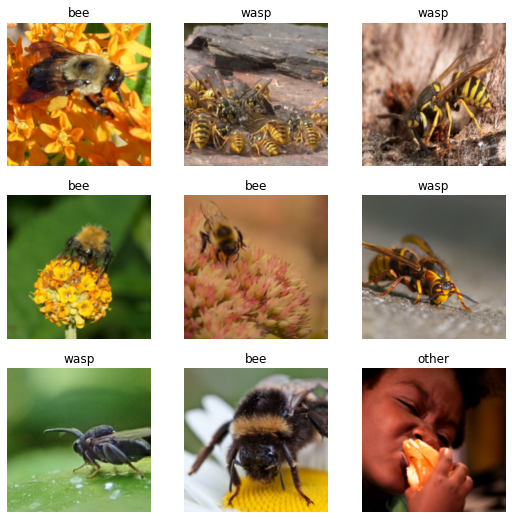

In [ ]:
data.show_batch()

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy, pretrained=true)
# learn.save('/content/gdrive/MyDrive/model_stages/resnet50-stage0')
# learn.summary()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
# learn.load('/content/gdrive/MyDrive/model_stages/resnet50-stage0')
best, step = learn.recorder.lr_find(start_lr=1e-04, end_lr=1, num_it=30) 
print(best, step)

KeyboardInterrupt: ignored

Model frozen up to parameter group #2 - training only fully contected classifying layers

fit_one_cycle - uses cyclical learning rates

* https://arxiv.org/abs/1506.01186
* https://iconof.com/1cycle-learning-rate-policy/
* https://course.fast.ai/videos/?lesson=6 - learning rate, transfer learning



# Make trainable -fully connected layers - classification - Total trainable params: 2,161,536

In [ ]:
# learn.load('/content/gdrive/MyDrive/model_stages/resnet50-stage0')
learn.recorder.fit_one_cycle(2, lr_max=slice(1e-4,1e-2)) 

epoch,train_loss,valid_loss,accuracy,time
0,0.349448,0.210761,0.937828,03:32
1,0.210715,0.162382,0.946585,03:32


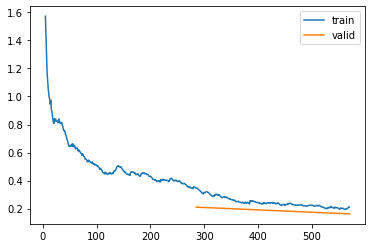

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.save('/content/gdrive/MyDrive/model_stages/resnet50-stage1')

Path('/content/gdrive/MyDrive/model_stages/resnet50-stage1.pth')

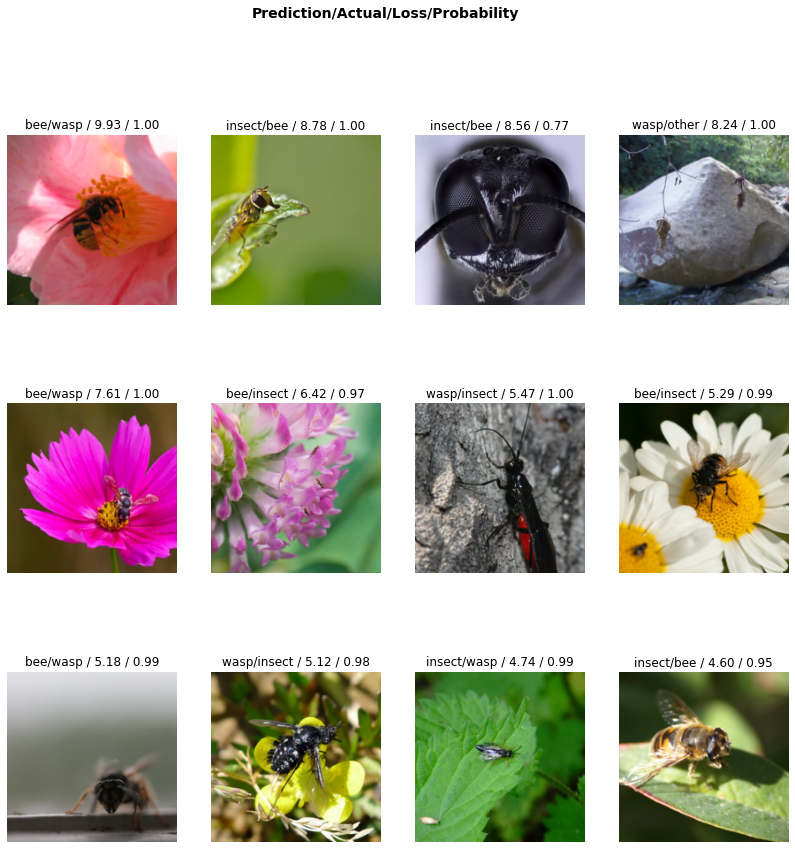

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_top_losses(12, figsize=(14,14))

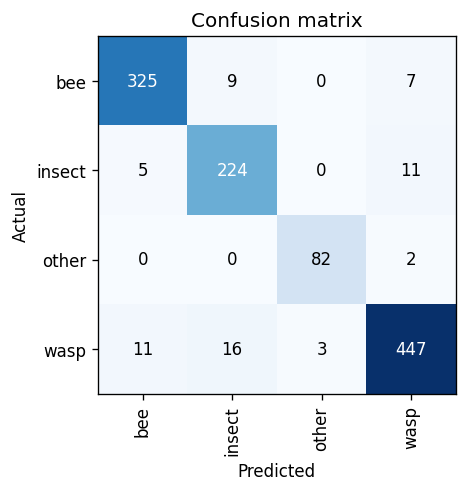

In [ ]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=120)

In [ ]:
learn.load('/content/gdrive/MyDrive/model_stages/resnet50-stage1')

https://www.analyticsvidhya.com/blog/2017/06/transfer-learning-the-art-of-fine-tuning-a-pre-trained-model/

https://medium.com/analytics-vidhya/understanding-fastai-v2-training-with-a-computer-vision-example-part-3-fastai-learner-and-a3ea85c6fe78

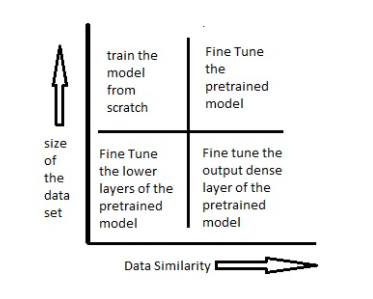

In [ ]:
def setTrainable(isTrainable, id1, id2, id3, layerName):
  for name, child in learn.model.named_children():
    if name == id1:
      for name, child in child.named_children():
        if name == id2:
          for name, child in child.named_children():
            if name == id3:
              for name, child in child.named_children():
                if name == layerName:
                  for param in child.parameters():
                    params.requires_grad = isTrainable

def isTrainable(id1, id2, id3, layerName):
  for name, child in learn.model.named_children():
    if name == id1:
      for name, child in child.named_children():
        if name == id2:
          for name, child in child.named_children():
            if name == id3:
              for name, child in child.named_children():
                if name == layerName:
                  for param in child.parameters():
                    return params.requires_grad

https://realpython.com/introduction-to-python-generators/

In [ ]:
# setTrainable(True, '0', '7', '2', 'conv3')
# isTrainable('0', '7', '2', 'conv3')

In [ ]:
learn.model[0][7][2]

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

# Make trainable - last conv layer - Total trainable params: 3,210,112


In [ ]:
# for param in learn.model.parameters():
#   param.requires_grad = False

learn.freeze()

for param in learn.model[0][7][2].conv3.parameters():
  param.requires_grad = True
 
for param in learn.model[0][7][2].bn3.parameters():
  param.requires_grad = True

learn.save('/content/gdrive/MyDrive/model_stages/resnet50-stage2')
learn.summary()

Sequential (Input shape: 128)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 64 x 112 x 11 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     128 x 256 x 56 x 56 
Conv2d                                    16384      False     
BatchNorm2d                               512        True      
ReLU                                                           
_________________________________________

9.999999747378752e-06 3.4145489280490438e-06


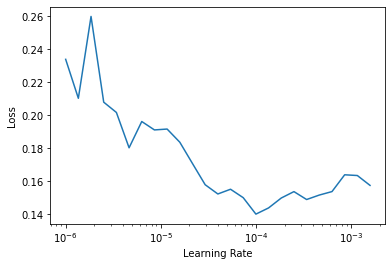

In [ ]:
# learn.load('/content/gdrive/MyDrive/model_stages/resnet50-stage2')
best, step = learn.recorder.lr_find(start_lr=1e-06, end_lr=1e-02, num_it=30) 
print(best, step)

epoch,train_loss,valid_loss,accuracy,time
0,0.174045,0.152546,0.948774,03:32


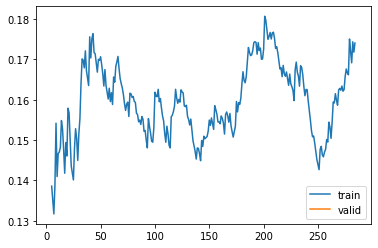

In [ ]:
# learn.load('/content/gdrive/MyDrive/model_stages/resnet50-stage2')
learn.recorder.fit_one_cycle(1, lr_max=slice(1e-6,1e-4)) 
learn.recorder.plot_loss()

In [ ]:
learn.save('/content/gdrive/MyDrive/model_stages/resnet50-stage3')

Path('/content/gdrive/MyDrive/model_stages/resnet50-stage3.pth')

In [ ]:
learn.freeze()

for param in learn.model[0][7][2].conv2.parameters():
  param.requires_grad = True

for param in learn.model[0][7][2].bn2.parameters():
  param.requires_grad = True  

for param in learn.model[0][7][2].conv3.parameters():
  param.requires_grad = True
 
for param in learn.model[0][7][2].bn3.parameters():
  param.requires_grad = True

# learn.save('/content/gdrive/MyDrive/model_stages/resnet50-stage3')
learn.summary()

Sequential (Input shape: 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     32 x 256 x 56 x 56  
Conv2d                                    16384      False     
BatchNorm2d                               512        True      
ReLU                                                           
__________________________________________

# Make trainable - last 2 conv layers - Total trainable params: 5,569,408

1.584893179824576e-05 3.981071586167673e-06


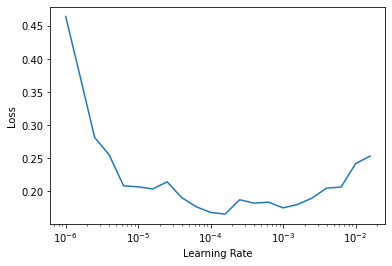

In [ ]:
# learn.load('/content/gdrive/MyDrive/model_stages/resnet50-stage3')
best, step = learn.recorder.lr_find(start_lr=1e-06, end_lr=1, num_it=30) 
print(best, step)

epoch,train_loss,valid_loss,accuracy,time
0,0.156023,0.157831,0.950963,03:34


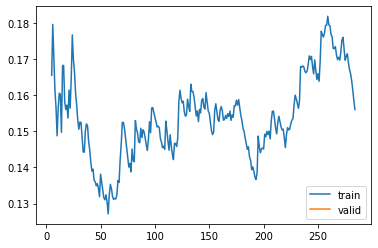

In [ ]:
# learn.load('/content/gdrive/MyDrive/model_stages/resnet50-stage3')
learn.recorder.fit_one_cycle(1, lr_max=slice(1e-6,1e-4)) 
learn.recorder.plot_loss()

In [ ]:
learn.save('/content/gdrive/MyDrive/model_stages/resnet50-stage4')

Path('/content/gdrive/MyDrive/model_stages/resnet50-stage4.pth')

Unfreeze all layers - whole net trainable

3.981071859016083e-06 5.011872303839482e-07


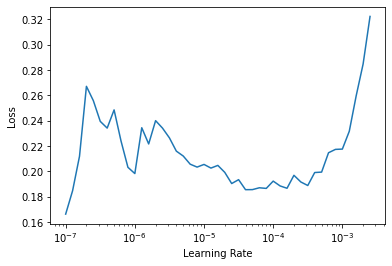

In [ ]:
# learn.load('/content/gdrive/MyDrive/model_stages/resnet50-stage4')
learn.unfreeze()
best, step = learn.recorder.lr_find(start_lr=1e-07, end_lr=1e-02, num_it=50) 
print(best, step)

epoch,train_loss,valid_loss,accuracy,time
0,0.164128,0.142427,0.952277,04:00


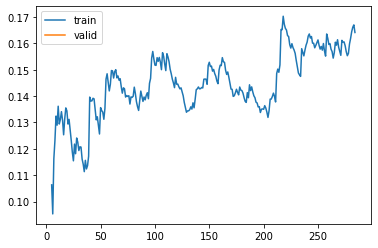

In [ ]:
# learn.load('/content/gdrive/MyDrive/model_stages/resnet50-stage4')
learn.recorder.fit_one_cycle(1, lr_max=slice(1e-6,1e-4)) 
learn.recorder.plot_loss()

In [ ]:
# learn.save('/content/gdrive/MyDrive/model_stages/resnet50-stage5')

In [ ]:
####### J.P  - SVM section
res50_model = learn.model ## assuming use of learn stored in stage 0 file
res50_conv = nn.Sequential(*list(res50_model.children())[:-1], nn.Sequential(AvgPool(ks=7), Flatten()))
for param in res50_conv.parameters():
    param.requires_grad = False
inputs, labels = data.one_batch()
outputs = res50_conv(inputs)
mr = np.copy(outputs.cpu())
ml = np.copy(labels.cpu())
for i in range( int(df_labels.shape[0]/ 32) -2 ):
  inputs, labels = data.one_batch()
  outputs = res50_conv(inputs)
  mr = np.vstack((mr, outputs.cpu()))
  ml = np.hstack((ml, labels.cpu()))
mr.data.shape

(11360, 2048)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

In [ ]:
# Make SVM with 3 different kernels
clf_lin = SVC(C= 1.0, kernel='linear')
clf_sqr = SVC(C= 1.0, kernel='poly', degree= 2)
clf_exp = SVC(C= 1.0, kernel='rbf')


In [ ]:
# Split data to test and train where test size is 20%
Xtrain, Xtest, ytrain, ytest = train_test_split(mr, ml, test_size=0.2)
clf_lin.fit(Xtrain, ytrain)
clf_sqr.fit(Xtrain, ytrain)
clf_exp.fit(Xtrain, ytrain)
preds_lin = clf_lin.predict(Xtest)
preds_sqr = clf_sqr.predict(Xtest)
preds_exp = clf_exp.predict(Xtest)
# Calculate accuracy
print("Accuracy score (Linear): {}".format(accuracy_score(ytest, preds_lin)))
print("Accuracy score (Square): {}".format(accuracy_score(ytest, preds_sqr)))
print("Accuracy score (Exp): {}".format(accuracy_score(ytest, preds_exp)))

Accuracy score (Linear): 0.9278169014084507
Accuracy score (Square): 0.9507042253521126
Accuracy score (Exp): 0.9529049295774648


Text(0.5, 1.0, 'Confusion Matrix')

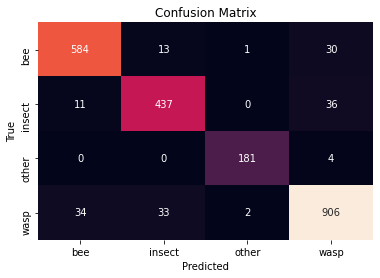

In [ ]:
#Linear kernel SVM
cm = confusion_matrix(ytest, preds_lin)
sns.heatmap(cm, annot=True, cbar=False, yticklabels=["bee","insect", "other", "wasp"], xticklabels=["bee","insect", "other", "wasp"], fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

Text(0.5, 1.0, 'Confusion Matrix')

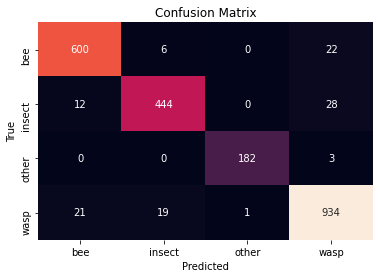

In [ ]:
#Square kernel SVM
cm = confusion_matrix(ytest, preds_sqr)
sns.heatmap(cm, annot=True, cbar=False, yticklabels=["bee","insect", "other", "wasp"], xticklabels=["bee","insect", "other", "wasp"], fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

Text(0.5, 1.0, 'Confusion Matrix')

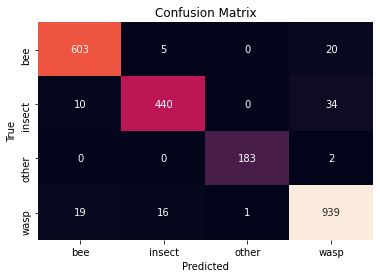

In [ ]:
#Exp kernel SVM
cm = confusion_matrix(ytest, preds_exp)
sns.heatmap(cm, annot=True, cbar=False, yticklabels=["bee","insect", "other", "wasp"], xticklabels=["bee","insect", "other", "wasp"], fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
# Linear kernel
print(classification_report(ytest, preds_lin, target_names=['bee', 'wasp', 'insect', 'other']))

              precision    recall  f1-score   support

         bee       0.93      0.93      0.93       628
        wasp       0.90      0.90      0.90       484
      insect       0.98      0.98      0.98       185
       other       0.93      0.93      0.93       975

    accuracy                           0.93      2272
   macro avg       0.94      0.94      0.94      2272
weighted avg       0.93      0.93      0.93      2272



In [ ]:
# Squared kernel
print(classification_report(ytest, preds_sqr, target_names=['bee', 'wasp', 'insect', 'other']))

              precision    recall  f1-score   support

         bee       0.95      0.96      0.95       628
        wasp       0.95      0.92      0.93       484
      insect       0.99      0.98      0.99       185
       other       0.95      0.96      0.95       975

    accuracy                           0.95      2272
   macro avg       0.96      0.95      0.96      2272
weighted avg       0.95      0.95      0.95      2272



In [ ]:
# Exp kernel
print(classification_report(ytest, preds_exp, target_names=['bee', 'wasp', 'insect', 'other']))

              precision    recall  f1-score   support

         bee       0.95      0.96      0.96       628
        wasp       0.95      0.91      0.93       484
      insect       0.99      0.99      0.99       185
       other       0.94      0.96      0.95       975

    accuracy                           0.95      2272
   macro avg       0.96      0.96      0.96      2272
weighted avg       0.95      0.95      0.95      2272



In [ ]:
# With cross validation
# Lin c-v
param_grid_lin = [
        {'C': [1, 10, 100, 1000], 'kernel': ['linear']} ]
# search for best parameters and fit SVM
clf_cv_lin = GridSearchCV(SVC(), param_grid_lin, verbose=1, scoring='f1_macro')
clf_cv_lin.fit(Xtrain, ytrain)
best_clf_cv_lin = clf_cv_lin.best_estimator_


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 11.8min finished


In [ ]:
print( "Lin= K: {}, C: {}, Gamma:{}".format(best_clf_cv_lin.kernel,
                                            best_clf_cv_lin.C, best_clf_cv_lin.gamma))

Lin= K: linear, C: 1, Gamma:scale


In [ ]:
# Sqr c-v 
param_grid_sqr = [ 
            {'C': [1, 10, 100], 'gamma': [1.0, 0.1, 0.001, 0.0001], 'kernel': ['poly'], 'degree': [2] } ]

clf_cv_sqr = GridSearchCV(SVC(), param_grid_sqr, verbose=1, scoring='f1_macro')
clf_cv_sqr.fit(Xtrain, ytrain)
best_clf_cv_sqr = clf_cv_sqr.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 57.3min finished


In [ ]:
print( "Sqr= K: {}, C: {}, Degree:{}, Gamma: {}".format(best_clf_cv_sqr.kernel, best_clf_cv_sqr.C, best_clf_cv_sqr.degree, best_clf_cv_sqr.gamma))

Sqr= K: poly, C: 1, Degree:2, Gamma: 1.0


In [ ]:
# Exp c-v
param_grid_exp = [ 
            {'C': [1, 10, 100], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']} ]

clf_cv_exp = GridSearchCV(SVC(), param_grid_exp, verbose=1, scoring='f1_macro')
clf_cv_exp.fit(Xtrain, ytrain)
best_clf_cv_exp = clf_cv_exp.best_estimator_




Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 23.5min finished


AttributeError: ignored

In [ ]:
print( "Exp= K: {}, C: {}, Degree:{}, Gamma: {}".format(best_clf_cv_exp.kernel, best_clf_cv_exp.C, best_clf_cv_exp.degree, best_clf_cv_exp.gamma))

Exp= K: rbf, C: 100, Degree:3, Gamma: 0.001


In [ ]:
# Acc summary for c-v SVM
preds_cv_lin = best_clf_cv_lin.predict(Xtest)
preds_cv_sqr = best_clf_cv_sqr.predict(Xtest)
preds_cv_exp = best_clf_cv_exp.predict(Xtest)
print("Accuracy score (Linear): {}".format(accuracy_score(ytest, preds_cv_lin)))
print("Accuracy score (Square): {}".format(accuracy_score(ytest, preds_cv_sqr)))
print("Accuracy score (Exp): {}".format(accuracy_score(ytest, preds_cv_exp)))

Accuracy score (Linear): 0.9278169014084507
Accuracy score (Square): 0.957306338028169
Accuracy score (Exp): 0.9564260563380281


In [ ]:
print(classification_report(ytest, preds_cv_lin, target_names=['bee', 'wasp', 'insect', 'other']))

              precision    recall  f1-score   support

         bee       0.93      0.93      0.93       628
        wasp       0.90      0.90      0.90       484
      insect       0.98      0.98      0.98       185
       other       0.93      0.93      0.93       975

    accuracy                           0.93      2272
   macro avg       0.94      0.94      0.94      2272
weighted avg       0.93      0.93      0.93      2272



In [ ]:
print(classification_report(ytest, preds_cv_sqr, target_names=['bee', 'wasp', 'insect', 'other']))

              precision    recall  f1-score   support

         bee       0.96      0.96      0.96       628
        wasp       0.96      0.93      0.94       484
      insect       0.99      0.98      0.99       185
       other       0.95      0.97      0.96       975

    accuracy                           0.96      2272
   macro avg       0.96      0.96      0.96      2272
weighted avg       0.96      0.96      0.96      2272



In [ ]:
print(classification_report(ytest, preds_cv_exp, target_names=['bee', 'wasp', 'insect', 'other']))

              precision    recall  f1-score   support

         bee       0.96      0.95      0.96       628
        wasp       0.96      0.93      0.94       484
      insect       0.99      0.98      0.99       185
       other       0.95      0.97      0.96       975

    accuracy                           0.96      2272
   macro avg       0.96      0.96      0.96      2272
weighted avg       0.96      0.96      0.96      2272



In [ ]:
## J.P test
learn2_ch1 = Learner(data, nn.Sequential(*list(res50_model.children())[:-1], nn.Sequential(AvgPool(ks=7), Flatten())))
learn2_ch1.summary()

Sequential (Input shape: 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        False     
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        False     
Conv2d                                    36864      False     
BatchNorm2d                               128        False     
____________________________________________________________________________
                     32 x 256 x 56 x 56  
Conv2d                                    16384      False     
BatchNorm2d                               512        False     
ReLU                                                           
__________________________________________